# Mapping 2
- Line of Interest (Circle)
- Intensity mapping
- Linear interpolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from IPython.display import Audio
from scipy.io.wavfile import write
from datetime import datetime
import subprocess
# @Jannis:
#    conda install -c conda-forge pyaudio
#    pip install pya
from pya import *
from scipy.interpolate import LinearNDInterpolator

In [2]:
def get_interpolated(array, index):
    if not hasattr(array, "__len__"): return array # if scalar
    return (1 - (index[0] % 1)) * get_interpolated(array[int(np.floor(index[0]))], index[1:]) + (index[0] % 1) * get_interpolated(array[int(np.ceil(index[0]))], index[1:])

In [3]:
# Doesnt Work!
def vectorized_interpolation(array, indices): # indices.shape (dim_array, desired number of interpolations)
    if len(indices) == 0: return array
    t = indices[0] % 1
    floor_indices = np.floor(indices[0]).astype(int)
    ceil_indices  = np.ceil (indices[0]).astype(int)
    return (1 - t) * vectorized_interpolation(array[floor_indices], indices[1:]) + t * vectorized_interpolation(array[ceil_indices], indices[1:])

In [4]:
#vectorized_interpolation(np.array([[0, 1, 2], [10, 20, 30]]), np.array([[0.5, 1], [0.5, 1]]))

# Simulation

In [5]:
import simulation

n = 128
sim_speed = 0.004
sim_fps = 400
duration = 6
frame_amount = duration * sim_fps

initial_state = np.array([[simulation.gaussian_impulse(x, y, n, offset=[-0.6, 0.0], width=0.15, impulse=0.07) for x in range(n)] for y in range(n)])

#potential = np.array([[simulation.parabola(x, y, n, offset=[0, 0], factor=10000) for x in range(n)] for y in range(n)])
potential = np.zeros((n, n))

multi_slit = [(-15, -13), (-8, -6), (-1, 1), (6, 8), (13, 15)]
double_slit = [(-4, -2), (2, 4)]
single_slit = [(-2, 2)]
slits = double_slit

frames = simulation.sim(n, sim_fps, duration, slits, sim_speed, initial_state=initial_state, potential=potential)

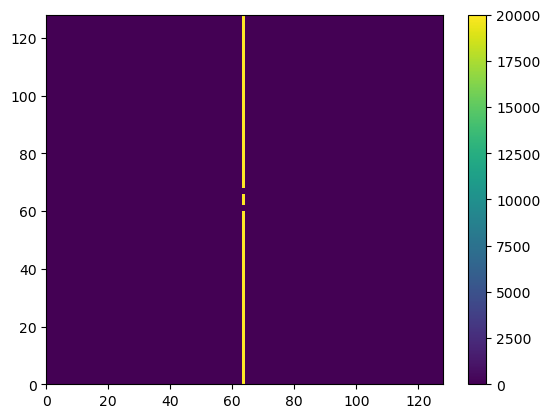

In [6]:
plt.pcolormesh(pow(np.abs(frames[0]), 2.0/3.0), cmap='inferno', vmin=0, vmax=1)
plt.pcolormesh(potential, vmin=0, vmax=20000)
plt.colorbar()
plt.show()

# Video

In [7]:
# create visual barrier for plot
def visual_barrier(barrier_gaps):
    start = 0
    rects = []
    for g in barrier_gaps:
        end = n//2 + g[0]
        rect = patches.Rectangle((n//2 - 1.5, start - 0.5), 1, end - start, linewidth=0, facecolor='#60b0ff')
        start = n//2 + g[1]
        rects.append(rect)
    rects.append(patches.Rectangle((n//2 - 1.5, start - 0.5), 1, n - start, linewidth=0, facecolor='#60b0ff'))
    return rects

video saved as output/simulation_2024_04_23-09_26_45.mp4


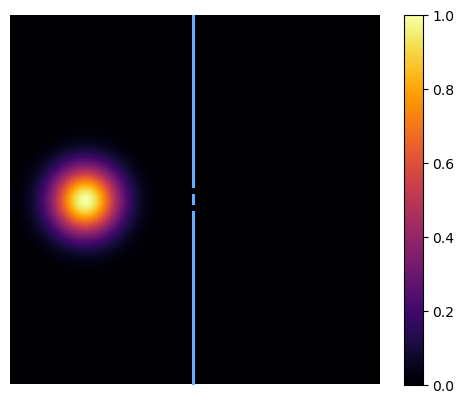

In [8]:
# FuncAnimation
video_fps = 20

fig, ax = plt.subplots()
plt.axis('off')  # big performance boost

data = pow(np.abs(frames[0]), 2.0/3.0)
cax = ax.imshow(data, cmap='inferno', vmin=0, vmax=1)
for b in visual_barrier(slits):
    ax.add_patch(b)
fig.colorbar(cax)  # no performance impact (?)

def animate(i):
    cax.set_array(pow(np.abs(frames[i * sim_fps // video_fps]), 2.0/3.0))

anim = animation.FuncAnimation(fig, animate, frames=frame_amount * video_fps // sim_fps)
video_filename = f'output/simulation_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'

anim.save(video_filename, fps=video_fps, dpi=150, bitrate=4000)

print(f'video saved as {video_filename}')

# Sonification

In [9]:
# circle of interest
def circle(radius, center):
    radians_per_sample = 2 * np.pi * frequency / sample_rate
    radians = np.arange(sample_rate * duration) * radians_per_sample
    x = (0.5 * n * (radius * np.cos(radians) + 1 + center[0]))#.astype(int)
    y = (0.5 * n * (radius * np.sin(radians) + 1 + center[1]))#.astype(int)
    return x, y

# line of interest
def line(start, end):
    t = np.arange(sample_rate * duration) / sample_rate * frequency % 1
    x = start[0]+n//2 + t * (end[0] - start[0])
    y = start[1]+n//2 + t * (end[1] - start[1])
    return x, y

In [10]:
# parameters
sample_rate = 44100
frequency = 220

# choose method
x, y = circle(radius=0.25, center=[0, 0])
# x, y = line(start=[-60, 0], end=[60, 0])



In [11]:
# Sonification
frames_indices = np.linspace(0, frame_amount - 1, sample_rate * duration, endpoint=False)

# No interpolation
#audio = frames[frames_indices.astype(int), y.astype(int), x.astype(int)]
#audio = np.square(np.abs(audio))

# Hardcoded interpolation
# Way faster than any other interpolation!
t = np.array([frames_indices, y, x]) % 1
floors = np.floor([frames_indices, y, x]).astype(int)
ceils  = np.ceil ([frames_indices, y, x]).astype(int)

audio = ((1-t[0]) * ((1-t[1]) * ((1-t[2]) * np.square(np.abs(frames[floors[0], floors[1], floors[2]]))
                              +     t[2]  * np.square(np.abs(frames[floors[0], floors[1], ceils [2]])))
                  +     t[1]  * ((1-t[2]) * np.square(np.abs(frames[floors[0], ceils [1], floors[2]]))
                              +     t[2]  * np.square(np.abs(frames[floors[0], ceils [1], ceils [2]]))))
          + t[0]  * ((1-t[1]) * ((1-t[2]) * np.square(np.abs(frames[ceils [0], floors[1], floors[2]]))
                              +     t[2]  * np.square(np.abs(frames[ceils [0], floors[1], ceils [2]])))
                  +     t[1]  * ((1-t[2]) * np.square(np.abs(frames[ceils [0], ceils [1], floors[2]]))
                              +     t[2]  * np.square(np.abs(frames[ceils [0], ceils [1], ceils [2]])))))

#audio = np.square(np.abs(audio))

print("Finished sonification")

Finished sonification


In [12]:
fade = 0.005
if fade > 0:
    fade_samples = int(sample_rate * fade)
    audio[:fade_samples]  *= np.square(np.linspace(start=0, stop=1, num=fade_samples, endpoint=False))
    audio[-fade_samples:] *= np.square(np.linspace(start=1, stop=0, num=fade_samples, endpoint=False))
audio_filename = f'output/sonification_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.wav'
write(audio_filename, sample_rate, np.round((audio - np.average(audio)) / np.max(np.abs(audio - np.average(audio))) * 32767).astype(np.int16))
print(f"Sonification saved as {audio_filename}")
Audio(audio, rate=sample_rate)

Sonification saved as output/sonification_2024_04_23-09_27_51.wav


In [13]:
# interactive plots
# conda install ipympl
%matplotlib widget

In [15]:
device_info();

idx Device Name              INP OUT    SR   INP-(Lo|Hi)  OUT-(Lo/Hi) (Latency in ms)
0   MacBook Pro-Mikrofon       1   0 44100     45     55    10    100
1   MacBook Pro-Lautsprecher   0   2 44100     10    100   9.7     20
2   eqMac                      2   2 44100     10    100   1.5     12
3   Microsoft Teams Audio      2   2 48000     10    100   1.3     11
4   ZoomAudioDevice            2   2 48000     10    100    33     43
5   MacBook + FastTrack        0   2 44100     10    100   9.7     20
6   FastTrack + Headphones     0   0 0      0      0     0      0
7   Multiausgangsgerät         0   2 44100     10    100   3.6     14


In [28]:
s = startup(device=1)

In [33]:
a1 = Asig(audio, sr=sample_rate)

In [47]:
plt.figure()
a1.iirfilter(30, order=2, btype='highpass').fade_in(0.005).fade_out(0.005).norm().stereo().play(onset=1, rate=2) # rate: resampling (oktave hoch/runter)
plt.close()

In [ ]:
# weitere feature: filter, nicht-linearer transfer, multichannel (stereo)

# time slice
a1[{2.0:4.0}].play()

# audio hinten anhängen
a1.x[-1:] = a1[{1.0:2.0}]

# audio überlagern (wie genau? vielleicht wie oben aber mit +=)

# advanced access modes
a1.x # extend(able bounds)
a1.b # bound(s shrinkable)
a1.o # overwrite

# spectrogram (nperseg für freq vs zeitauflösung)
a1.to_stft(nperseg=4096).plot(ylim=(0, 2000), scale='log')

# get
numpy_array_of_audio = a1.sig

# Klassen
#Asig Aspec Astft Arecorder Aserver
#Ugen

# load file
Asig('filename.wav')

Astft('_stft'): 1 x 264600 @ 44100 Hz = 6.000 s cn=['0']

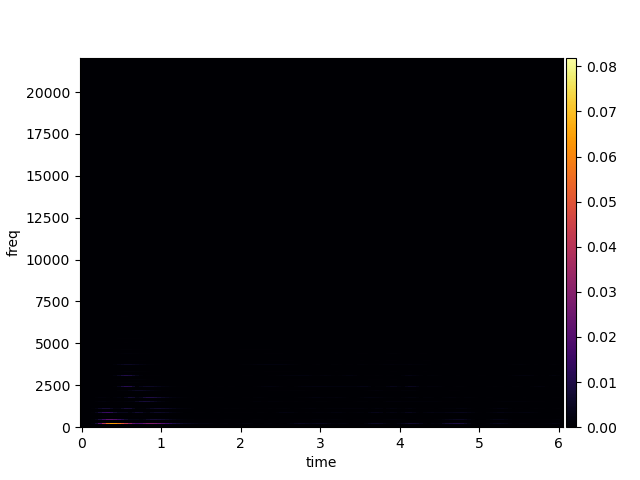

In [43]:
plt.figure()
a1.to_stft(nperseg=4096).plot()

In [ ]:
plt.figure()
plt.plot(audio)

# Combine Video & Audio

In [14]:
combined_filename = f'output/combination_{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}.mp4'

# Construct the ffmpeg command to combine video and audio
ffmpeg_command = [
    'ffmpeg',
    '-i', video_filename,   # Input video file
    '-i', audio_filename,   # Input audio file
    '-c:v', 'copy',         # Copy the video stream
    '-c:a', 'aac',          # Encode the audio to AAC (necessary for some formats)
    '-shortest',            # Finish encoding when the shortest input stream ends
    combined_filename         # Output file
]

# Execute the command
subprocess.run(ffmpeg_command)

ffmpeg version 7.0 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/7.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvino --enab

CompletedProcess(args=['ffmpeg', '-i', 'output/simulation_2024_04_23-09_26_45.mp4', '-i', 'output/sonification_2024_04_23-09_27_51.wav', '-c:v', 'copy', '-c:a', 'aac', '-shortest', 'output/combination_2024_04_23-09_27_58.mp4'], returncode=0)